In [1]:
import torch
import gym
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': [10,5]})
import numpy as np
from sklearn.linear_model import LinearRegression

In [32]:
env = gym.make('FrozenLake-v0', is_slippery=True) 
# more environments to speed up learning??
num_actions = env.env.nA
num_states = env.env.nS

In [10]:
# change exploration epsilon greedy, decaying epsilon?
def epsilon_greedy_action(q, state):
    
    current_q = q[state, :]
    
    if torch.rand(1) < epsilon:
        action = torch.randint(num_actions, (1,))
    else:
        action = torch.tensor(np.random.choice(np.where(current_q == current_q.max())[0])) # argmax with random tie-breaking
        #action = torch.argmax(current_q) # slow and doesn't learn ????
        
    return action

def q_learning_update(prev_state, prev_action, state, reward):
    
    current_q = q[state, :]
    
    q[prev_state, prev_action] += learning_rate * (reward + discount * max(current_q) - q[prev_state, prev_action])

In [33]:
# initialise q to zeros, initial optimistic q values?
q = torch.zeros((num_states, num_actions))

discount = 1
learning_rate = 0.05
epsilon = 0.1
episodes = 10000

episode_rewards = torch.zeros(episodes)
for episode in tqdm(range(episodes)):

    # first action from start state
    start_state = env.reset()
    action = epsilon_greedy_action(q, start_state)
    prev_state = start_state
    prev_action = action

    # get reward from env
    state, reward, terminal, info = env.step(action.numpy().item())

    while terminal is False: # add terminal to update rule
        # choose next action
        action = epsilon_greedy_action(q, state)

        # update q values for last step
        q_learning_update(prev_state, prev_action, state, reward)
        prev_state = state
        prev_action = action

        # take next step and get reward from env
        state, reward, terminal, info = env.step(action.numpy().item())

    else:
        # final update
        q[prev_state, prev_action] += learning_rate * (reward - q[prev_state, prev_action])

    episode_rewards[episode] = reward

    

100%|██████████| 10000/10000 [00:39<00:00, 253.87it/s]


(0.0, 0.5)

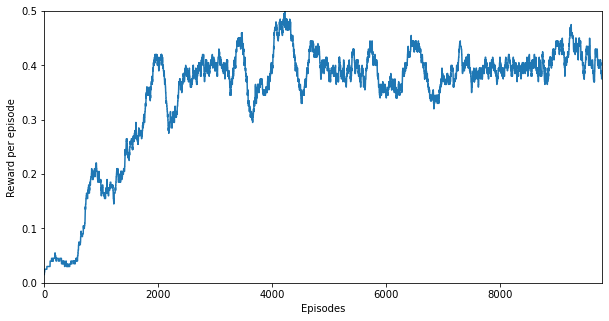

In [34]:
# return per episode plot as moving average
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

reward_move_ave = moving_average(episode_rewards.numpy(), 200)
plt.plot(reward_move_ave)
plt.xlabel("Episodes")
plt.ylabel("Reward per episode")
plt.xlim(0, len(reward_move_ave))
plt.ylim(0, reward_move_ave.max())

(0.0, 3446.0)

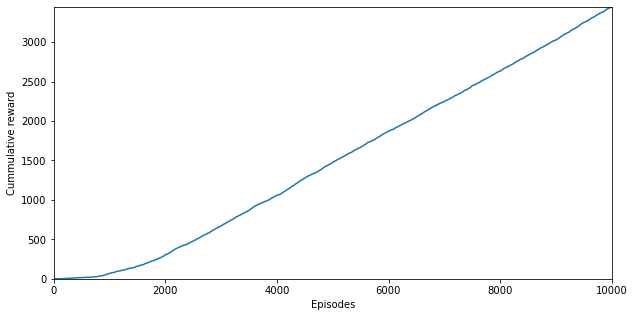

In [35]:
# cumulative reward plot
cum_rewards = torch.cumsum(episode_rewards, dim=0)
plt.plot(cum_rewards)
plt.xlabel("Episodes")
plt.ylabel("Cummulative reward")
plt.xlim(0, episodes)
plt.ylim(0, cum_rewards[-1])


In [36]:
linear_start = 2000
x = np.array(range(episodes)[-(episodes-linear_start):]).reshape(-1, 1)
y = cum_rewards[-(episodes-linear_start):].reshape(-1, 1)
reg = LinearRegression().fit(x,y)
reg.coef_

array([[0.39332025]])